In [25]:
"""Load the dataset and dataset config"""
from karanir.datasets.playroom_dataset import PlayroomDataset
from torch.utils.data import DataLoader
dataset_dir = "/Users/melkor/Documents/datasets/Playroom"

In [26]:
"""Arguments or the dataset config"""
import argparse
parser = argparse.ArgumentParser()
parser.add_argument("--compute_flow",           default = False)
parser.add_argument("--precompute_flow",        default = False)
args = parser.parse_args(args = [])

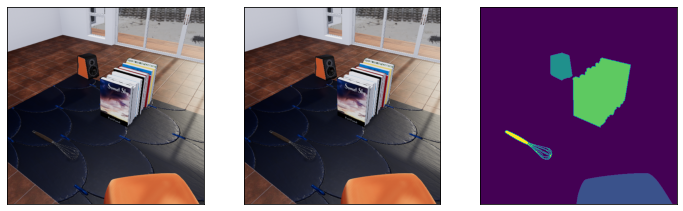

In [27]:
import matplotlib.pyplot as plt
dataset = PlayroomDataset(True, args, dataset_dir = dataset_dir, flow = False)
loader = DataLoader(dataset, batch_size = 3, shuffle = True)

for sample in loader:break;

def visualize_sample(sample, fig_name = "visualize sample", n = 12):
    fig = plt.figure(fig_name, frameon = False, figsize = (n,n * 3))
    for i,k in enumerate(sample):
        ax = fig.add_subplot(1,3,i+1)
        ax.imshow(sample[k][0])
        plt.xticks([]);plt.yticks([]) # ignore all the label tick and just show the pics
    plt.show()

visualize_sample(sample)

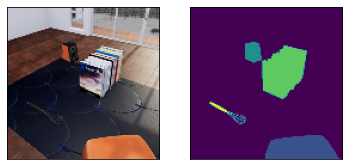

In [28]:
"""Build the SceneNet that performs visual grouping with conditions"""
from karanir.thanagor.perception import SceneNet
from karanir.thanagor.model import config
import torchvision

img = sample["img1"] / 255.
img = torchvision.transforms.Resize([128,128])(img.permute(0,3,1,2))

gt_seg = sample["gt_segment"]
gt_seg = torchvision.transforms.Resize([128,128])(gt_seg)

""" Down Cast the images into the resolution of (128,128)"""
fig = plt.figure("down sample images")
ax1 = fig.add_subplot(121)
ax1.imshow(img[0].permute(1,2,0)); plt.xticks([]); plt.yticks([])
ax2 = fig.add_subplot(122)
ax2.imshow(gt_seg[0]); plt.xticks([]); plt.yticks([])
plt.show()

In [29]:
"""Actual Calculations and the small sample training"""
scenenet = SceneNet(config)

outputs = scenenet(img, gt_seg)

"""Optimization over the loss and KL-divergence"""
loss = outputs["loss"]
print(f"loss:{loss}")

shape:[3, 3, 16384, 26] max:16383 min:0
shape:[3, 16384, 26] max:0.14541009068489075 min:-0.2560555040836334
shape:[3, 3, 4096, 26] max:4095 min:0
shape:[3, 4096, 26] max:0.10884594917297363 min:-0.2264893352985382
loss:0.0


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def generate_local_indices(img_size, K, padding = 'constant'):
    H, W = img_size
    indice_maps = torch.arange(H * W).reshape([1, 1, H, W]).float()

    # symetric_padding
    assert K % 2 == 1 # assert K is odd
    half_K = int((K - 1) / 2)

    assert padding in ["reflection", "constant"]
    if padding == "constant":
        pad_fn = torch.nn.ReflectionPad2d(half_K)
    else:
        pad_fn = torch.nn.ConstantPad2d(half_K)
    
    indice_maps = pad_fn(indice_maps)
    local_inds = F.unfold(indice_maps, kernel_size = K, stride = 1)
    local_inds = local_inds.permute(0,2,1)
    return local_inds

inds = generate_local_indices([64,64],3)
print(inds)
print(inds.shape)

tensor([[[  65.,   64.,   65.,  ...,   65.,   64.,   65.],
         [  64.,   65.,   66.,  ...,   64.,   65.,   66.],
         [  65.,   66.,   67.,  ...,   65.,   66.,   67.],
         ...,
         [4028., 4029., 4030.,  ..., 4028., 4029., 4030.],
         [4029., 4030., 4031.,  ..., 4029., 4030., 4031.],
         [4030., 4031., 4030.,  ..., 4030., 4031., 4030.]]])
torch.Size([1, 4096, 9])


In [24]:
from karanir.thanagor.perception.propagation import GraphPropagation
from karanir.utils.tensor import local_to_sparse_global_affinity

connection = outputs["connections"][0]
prop = GraphPropagation()

print(connection.shape)
B, N, K = connection.shape

features = torch.randn([B,N,128]).softmax(dim = -1)

adj = connection.softmax(-1)
adj = adj / torch.max(adj, dim = -1, keepdim = True)[0].clamp(min = 1e-12)

adj = local_to_sparse_global_affinity()

from karanir.utils.tensor import stats_summary
stats_summary(adj)

prop_list = prop(features, adj)

torch.Size([3, 16384, 26])
shape:[3, 16384, 26] max:1.0 min:0.7856195569038391


RuntimeError: shape '[3, 16384, 16384]' is invalid for input of size 1277952

In [5]:
import functools
import tensorflow as tf
import numpy as np
# Modified from https://github.com/deepmind/multi_object_datasets to
# work in TensorFlow 2

COMPRESSION_TYPE = tf.io.TFRecordOptions.get_compression_type_string('GZIP')
IMAGE_SIZE = [64, 64]
# The maximum number of foreground and background entities in each variant
# of the provided datasets. The values correspond to the number of
# segmentation masks returned per scene.
MAX_NUM_ENTITIES = {
    'train': 7,
    'six_objects': 10,
    'empty_room': 4,
    'identical_color': 10
}
BYTE_FEATURES = ['mask', 'image']


def feature_descriptions(max_num_entities):
  """Create a dictionary describing the dataset features.
  Args:
    max_num_entities: int. The maximum number of foreground and background
      entities in each image. This corresponds to the number of segmentation
      masks returned per scene.
  Returns:
    A dictionary which maps feature names to `tf.Example`-compatible shape and
    data type descriptors.
  """
  return {
      'image': tf.io.FixedLenFeature(IMAGE_SIZE+[3], tf.string),
      'mask': tf.io.FixedLenFeature([max_num_entities]+IMAGE_SIZE+[1], tf.string),
  }


def _decode(example_proto, features):
  # Parse the input `tf.Example` proto using a feature description dictionary.
  single_example = tf.io.parse_single_example(example_proto, features)
  for k in BYTE_FEATURES:
    single_example[k] = tf.squeeze(tf.io.decode_raw(single_example[k], tf.uint8),
                                   axis=-1)
  return single_example


def dataset(tfrecords_path, dataset_variant, read_buffer_size=None,
            map_parallel_calls=None):
  """Read, decompress, and parse the TFRecords file.
  Args:
    tfrecords_path: str. Path to the dataset file.
    dataset_variant: str. One of ['train', 'six_objects', 'empty_room',
      'identical_color']. This is used to identify the maximum number of
      entities in each scene. If an incorrect identifier is passed in, the
      TFRecords file will not be read correctly.
    read_buffer_size: int. Number of bytes in the read buffer. See documentation
      for `tf.data.TFRecordDataset.__init__`.
    map_parallel_calls: int. Number of elements decoded asynchronously in
      parallel. See documentation for `tf.data.Dataset.map`.
  Returns:
    An unbatched `tf.data.TFRecordDataset`.
  """
  if dataset_variant not in MAX_NUM_ENTITIES:
    raise ValueError('Invalid `dataset_variant` provided. The supported values'
                     ' are: {}'.format(list(MAX_NUM_ENTITIES.keys())))
  max_num_entities = MAX_NUM_ENTITIES[dataset_variant]
  raw_dataset = tf.data.TFRecordDataset(
      tfrecords_path, compression_type=COMPRESSION_TYPE,
      buffer_size=read_buffer_size)
  features = feature_descriptions(max_num_entities)
  partial_decode_fn = functools.partial(_decode, features=features)
  return raw_dataset.map(partial_decode_fn,
                         num_parallel_calls=map_parallel_calls)

tf_records_path = '/Users/melkor/Documents/datasets/objects_room_train.tfrecords'

train_dataset = dataset(tf_records_path, "train")

for sample in train_dataset:
    sample;
    print(sample)
    break

NotFoundError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} /Users/melkor/Documents/datasets/objects_room_train.tfrecords; No such file or directory [Op:IteratorGetNext] name: 